# Hello and welcome to this small showcase of our Diffusion Limited Aggregation program!

Simon van Staalduine, 4663764
Mike Hoogeveen, 

In this notebook, we will explain the approaches we took to bring the DLA to life. The main idea was to use as many dimension-ambivalent classes as possible, and specialize when necessary. Our implementation relies on generating a certain number of Brownian particles, analyze their random walk, and grow the tree accordingly. The program here also lends itself to an adjustable basin of Brownian particles, as well as customizable quantity and location of seed particles. Using a python script that interacts with Blender, the 3D simulations can be rendered with much more direct control than matplotlib allows for.

## But what is it about?
Diffusion Limited Aggregation (DLA) is about the following process: A particle diffuses through a space, encounters a seed point, or a tree of seed points, and if the particle finds itself within a certain radius of a seed point, it will fix its position and become another seed point. One crucial aspect of these simulations is that the particles have to come from outside the general space where the seed points are. A consequence of this that will be immediately evident is that this will result in a fairly elegant distribution of probability of where the next seed point will grow on the tree. This almost always results in branch-like structures.

## Documentation
The code in this notebook is divided into two parts: In this section, the classes for both the Brownian particle and the seed tree are defined, and specialized to two and three dimensions. Later on, these classes will be used in all sorts of examples to showcase the versatility of this model. For now, we just import some libraries that will help us later on.

In [78]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm


### Brownian particles
Now let's get to the meat of the program. In our implementation of Brownian particles, we generate an array of movement of a fixed length rand_len. We also generate an initial position according to which function of the particle is called. For every time-step a particle can move a radius r in a uniformly random direction.

Below you can see the general class of the Brownian particle This class mostly sets up the storage needed in the specialized cases. One function of note here is the start_pos_rect function, which generates a random starting location based on coordinates denoting a rectangle (in 2D) or a box (in 3D). Another is the gen_path function which takes the random movement that was generated earlier, and sums it over the array, also with the initial position. The resulting array contains the path that the particle is walking on.

In [79]:
class ParticleBrown:
    def __init__(self, startCoords, endCoords, rand_len=512, r=1.0):
        self.dim = len(startCoords)
        self.pos = np.zeros((self.dim, rand_len), dtype=float)
        self.r = r
        self.d = np.zeros(self.dim)
        self.angle = np.zeros(self.dim - 1)
        self.rand_int = rand_len
        self.angle_array = np.array([self.dim - 1, self.rand_int])
        self.path = np.zeros((self.dim, rand_len))

    def gen_path(self):
        self.path = np.cumsum(self.d, axis=1)
        for i in range(self.dim):
            self.path[i] += self.pos[i]
        return self.path

    def start_pos_rect(self, start_rect, end_rect):
        for i in range(self.dim):
            self.pos[i] = np.random.uniform(start_rect[i], end_rect[i])


### Specialized classes
Below are the specialized classes for the 2D and 3D Brownian particles. Both of them have a spherical initial position function and both have a specialised movement generation function. The formulas for uniformly picking a direction in 3D were taken from this: https://mathworld.wolfram.com/SpherePointPicking.html

In [80]:

class Brown2D(ParticleBrown):
    def __init__(self, startCoords, endCoords, rand_len=512, r=1, spawn_r=0):
        super().__init__(startCoords, endCoords, rand_len, r)
        self.dim = 2
        self.pos_theta = 0.0

    def gen_rand(self):
        self.angle_array = np.random.uniform(0, 2 * np.pi, self.rand_int)
        self.d = np.array([np.cos(self.angle_array) * self.r, np.sin(self.angle_array) * self.r])

    def start_pos_circle(self, spawn_r=0.0):
        self.pos_theta = np.random.uniform(0, 2 * np.pi)
        self.pos[0] = np.cos(self.pos_theta) * spawn_r
        self.pos[1] = np.sin(self.pos_theta) * spawn_r


class Brown3D(ParticleBrown):
    def __init__(self, startCoords, endCoords, rand_len=512, r=1):
        super().__init__(startCoords, endCoords, rand_len, r)
        self.dim = 3
        self.pos_theta = 0.0
        self.pos_phi = 0.0

    def start_pos_sphere(self, spawn_r=0.0):
        self.pos_theta = np.random.uniform(0, 2 * np.pi)
        self.pos_phi = np.arccos(np.random.uniform(-1, 1))

        self.pos[0] = spawn_r * np.sin(self.pos_phi) * np.cos(self.pos_theta)
        self.pos[1] = spawn_r * np.sin(self.pos_phi) * np.sin(self.pos_theta)
        self.pos[2] = spawn_r * np.cos(self.pos_phi)

    def gen_rand(self):
        self.angles_theta = np.random.uniform(0, 2 * np.pi, self.rand_int)
        self.angles_phi = np.arccos(np.random.uniform(-1, 1, self.rand_int))
        self.d = np.array([self.r * np.sin(self.angles_phi) * np.cos(self.angles_theta),
                           self.r * np.sin(self.angles_phi) * np.sin(self.angles_theta),
                           self.r * np.cos(self.angles_phi)])


### The trees
Below is a the class for generating the tree structures in the model. 

Check_path is an algorithm that goes over all steps of a Brownian particle, and returns the index of the path array where the particle first encounters the tree. 

add_seed simply adds a seed to the tree.

gen_link_graph creates a scatter plot that gives the index of the particle that any new particle is bonded to. An example will be shown later.

adjust_origin shifts the location of the whole tree such that its center of mass is at the origin.

In [91]:
class DLATree:
    def __init__(self, ini_coords, r=0.1):
        self.seed_array = np.array(ini_coords)
        self.r = r
        self.link_tree = []
        self.connect_node = 0
        self.link_fig = plt.figure()
        self.link_ax = self.link_fig.add_subplot()

    def check_path(self, path):
        check_indices = -1
        self.connect_node = -1
        for k, seed in enumerate(self.seed_array):
            temp_path = np.zeros((len(seed), np.shape(path)[1]))
            for i in range(len(seed)):
                temp_path[i] = path[i] - seed[i]
            temp_path = np.linalg.norm(temp_path, axis=0)
            check_path = np.where(abs(temp_path) < self.r, True, False)
            seed_indices = np.where(check_path == 1)[0]
            if len(seed_indices) > 0:
                if check_indices == -1:
                    check_indices = seed_indices[0]
                    self.connect_node = k
                elif seed_indices[0] < check_indices:
                    check_indices = seed_indices[0]
                    self.connect_node = k
        if self.connect_node > -1:
            self.link_tree.append([self.connect_node, np.shape(self.seed_array)[0]])
        return check_indices

    def add_seed(self, coords):
        self.seed_array = np.append(self.seed_array, [coords], axis=0)
        return len(self.seed_array)

    def gen_link_graph(self, colors):
        for i in range(len(self.link_tree)):
            self.link_ax.scatter(self.link_tree[i][1], self.link_tree[i][0], color=colors, s=5)
            self.link_ax.set_xlabel('Newest addition to tree')
            self.link_ax.set_ylabel('Which seed the newest addition is attached to')

    def adjust_origin(self):
        mean_temp = np.mean(self.seed_array, axis=0)
        self.seed_array = np.subtract(self.seed_array, mean_temp)
        
class DLA3DTree(DLATree):
    def __init__(self, ini_coords, r=0.2):
        super().__init__(ini_coords, r)

    def gen_tree_graph(self, colors):
        for i in range(len(self.seed_array)):
            self.link_ax.scatter(self.seed_array[i][0], self.seed_array[i][1], s=30, color=next(colors), alpha=1)


## Operating the program
Now that the definitions are out of the way, we will show three examples of how these aggregates can grow. The first of these examples is a classical one. A seed point in the center of a plane, that grows with particles diffusing from a circle outside the tree.


 37%|█████████████████████████████▉                                                   | 74/200 [00:22<00:52,  2.40it/s]


 70%|████████████████████████████████████████████████████████                        | 140/200 [00:57<00:24,  2.44it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:52<00:00,  1.78it/s]


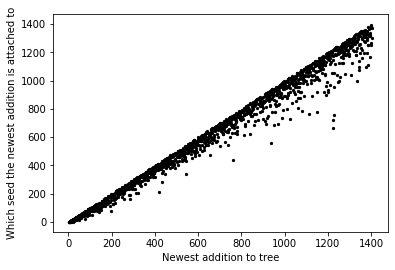

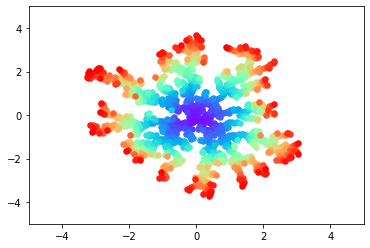

In [82]:
origin = np.array([-3, 0.6])
final_coords = np.array([3, 0.7])
z_plane = 0


George = DLATree([[0.0, 0.0]], r=0.1)
spawn_r = 3
max_dist = 0.0

for j in tqdm(range(200)):
    Brownian_array = [Brown2D(origin, final_coords, rand_len=512, r=.08) for i in
                      range(10)]

    for i in Brownian_array:
        i.start_pos_circle(max_dist)
        i.gen_rand()
        path = i.gen_path()
        # plt.scatter(i.path[0], i.path[1], s=40, alpha=0.5)
        indices = George.check_path(path)
        if indices > -1:
            George.add_seed(i.path[:, indices])

            # max_z = np.amax(George.seed_array, axis=0)[2]
            # origin[2] = max_z
            # final_coords[2] = max_z
            seed_l = np.linalg.norm(i.path[:, indices])
            max_dist = np.maximum(max_dist, np.linalg.norm(i.path[:, indices]))
            George.adjust_origin()

colors = iter(cm.rainbow(np.linspace(0, 1, len(George.seed_array))))

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(George.seed_array)):
    ax.scatter(George.seed_array[i][0], George.seed_array[i][1], s=30, color=next(colors), alpha=1)


plt.xlim(-5, 5)
plt.ylim(-5, 5)

George.gen_link_graph('black')

plt.show()

# with open('coords.txt', 'w') as f:
#     f.write(str(np.shape(George.seed_array)[0]) + '\n')
#     f.write(str(np.shape(George.link_tree)[0]))
#     f.write('\n')
#     for coord in George.seed_array:
#         f.write(str(coord))
#         f.write('\n')
#     for link in George.link_tree:
#         f.write(str(link))
#         f.write('\n')



## DLA Properties
Now would be a good time to talk about behaviours we see in DLA. In the two figures plotted above, you will likely see a scatterplot that is mostly a straight line that tapers out as newer particles are added. Underneath you can see a representation of the tree that was created.

In the rainbow-like figure above, color represents when that particle was added to the tree. Violet being among the first particles, and red showing the newest. 

In the graph, overwhelmingly the particles on the edge of the tree are the most red, therefore the most new. There are very few red particles near the inside of the tree. Another trend that we see, is that branches do not cross each other, and grow relatively straight out from the center. These branches also become wider as they grow. 

Another result of this behaviour are the gaps that form between branches. As these get filled in with newer particles, it becomes harder and harder for particles to diffuse into these gaps. This makes them a permanent feature of any tree grown with DLA.

### Spherical Example
In this example, we will use a ring of seed points, and a particle basin at the center of that ring, to replicate a figure in this paper:  https://iovs.arvojournals.org/article.aspx?articleid=2179252 

The link graph in this is interesting to see, as there is still the line along x=y signifying that new particles are being fixed to new particles, but the band is much wider, thanks to the higher availability of trees to grow off of in any direction.



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  6%|████▉                                                                             | 6/100 [00:00<00:01, 57.29it/s]

 11%|████████▉                                                                        | 11/100 [00:00<00:01, 53.02it/s]

 16%|████████████▉                                                                    | 16/100 [00:00<00:01, 48.49it/s]

 20%|████████████████▏                                                                | 20/100 [00:00<00:01, 44.41it/s]

 24%|███████████████████▍                                                             | 24/100 [00:00<00:01, 41.01it/s]

 28%|██████████████████████▋                                                          | 28/100 [00:00<00:01, 37.43it/s]

 32%|█████████████████████████▉                                                       | 32/100 [00:00<00:02, 33.08it/s]

 36%|█████████████████████████

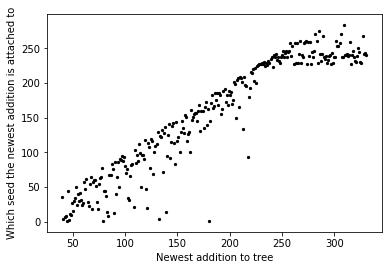

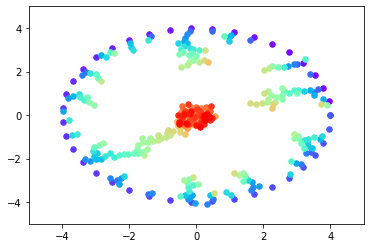

In [89]:
r_seeds = 4
nr_particles = 100
grid_nr = 40

#Here we just generate a circle of seed points
theta_grid = np.linspace(0, 2*np.pi, grid_nr)
x_grid = r_seeds * np.cos(theta_grid)
y_grid = r_seeds * np.sin(theta_grid)

start_seeds = np.zeros((grid_nr, 2))
count = 0
for i in range(grid_nr):
    start_seeds[count, 0] = x_grid[i]
    start_seeds[count, 1] = y_grid[i]
    count += 1
    

Jerry = DLATree(start_seeds, r=0.2)

#This can probably be made into a function, but there are still too many subtle adaptations that have to be 
#made for each run that I'll leave it in the main()
for j in tqdm(range(nr_particles)):
    Brownian_array = [Brown2D([-0.1, 0.1], [-0.1, 0.1], rand_len=512, r=.1) for i in
                      range(10)]

    for i in Brownian_array:
        i.start_pos_rect([-0.5, -0.5], [0.5, 0.5])
        i.gen_rand()
        path = i.gen_path()
        indices = Jerry.check_path(path)
        if indices > -1:
            Jerry.add_seed(i.path[:, indices])

            # max_z = np.amax(George.seed_array, axis=0)[2]
            # origin[2] = max_z
            # final_coords[2] = max_z
            seed_l = np.linalg.norm(i.path[:, indices])
            max_dist = np.maximum(max_dist, np.linalg.norm(i.path[:, indices]))

colors = iter(cm.rainbow(np.linspace(0, 1, len(Jerry.seed_array))))

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(Jerry.seed_array)):
    ax.scatter(Jerry.seed_array[i][0], Jerry.seed_array[i][1], s=30, color=next(colors), alpha=1)


plt.xlim(-5, 5)
plt.ylim(-5, 5)

Jerry.gen_link_graph('black')

plt.show()


### Grid Example
And last but not least, we can discuss corals! By laying down a flat grid of seed points, and generating points from a basin above that grid, we can simulate the growth of actual trees.



  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

  3%|██▍                                                                               | 6/200 [00:00<00:03, 51.39it/s]

  5%|████                                                                             | 10/200 [00:00<00:04, 44.01it/s]

  6%|█████▎                                                                           | 13/200 [00:00<00:05, 35.12it/s]

  8%|██████▍                                                                          | 16/200 [00:00<00:06, 30.22it/s]

 10%|███████▋                                                                         | 19/200 [00:00<00:06, 26.16it/s]

 11%|████████▉                                                                        | 22/200 [00:00<00:07, 23.09it/s]

 12%|██████████▏                                                                      | 25/200 [00:00<00:08, 20.50it/s]

 14%|██████████▉              

 44%|████████████████████████████████████                                             | 89/200 [00:20<00:51,  2.15it/s]

 45%|████████████████████████████████████▍                                            | 90/200 [00:21<00:49,  2.23it/s]

 46%|████████████████████████████████████▊                                            | 91/200 [00:21<00:47,  2.30it/s]

 46%|█████████████████████████████████████▎                                           | 92/200 [00:22<00:46,  2.34it/s]

 46%|█████████████████████████████████████▋                                           | 93/200 [00:22<00:45,  2.36it/s]

 47%|██████████████████████████████████████                                           | 94/200 [00:23<00:44,  2.37it/s]

 48%|██████████████████████████████████████▍                                          | 95/200 [00:23<00:44,  2.37it/s]

 48%|██████████████████████████████████████▉                                          | 96/200 [00:23<00:44,  2.34it/s]

 48%|███████████████████████████

 76%|█████████████████████████████████████████████████████████████▏                  | 153/200 [00:53<00:12,  3.68it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 154/200 [00:53<00:16,  2.77it/s]

 78%|██████████████████████████████████████████████████████████████                  | 155/200 [00:54<00:19,  2.30it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 156/200 [00:55<00:21,  2.08it/s]

 78%|██████████████████████████████████████████████████████████████▊                 | 157/200 [00:55<00:22,  1.90it/s]

 79%|███████████████████████████████████████████████████████████████▏                | 158/200 [00:56<00:24,  1.74it/s]

 80%|███████████████████████████████████████████████████████████████▌                | 159/200 [00:57<00:24,  1.66it/s]

 80%|████████████████████████████████████████████████████████████████                | 160/200 [00:57<00:25,  1.58it/s]

 80%|███████████████████████████

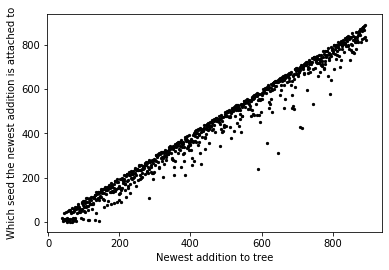

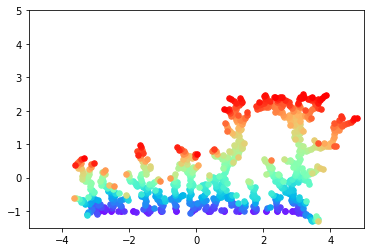

In [90]:
origin = np.array([-7, 0.6])
final_coords = np.array([7, 0.7])
z_plane = 0


r_seeds = 3
nr_particles = 200
grid_nr = 40

#Here we just generate a circle of seed points
theta_grid = np.linspace(0, 2*np.pi, grid_nr)
x_grid = r_seeds * np.cos(theta_grid)
y_grid = r_seeds * np.sin(theta_grid)

start_seeds = np.zeros((grid_nr, 2))
count = 0
for i in range(grid_nr):
    start_seeds[count, 0] = x_grid[i]
    start_seeds[count, 1] = -1
    count += 1
    

John = DLATree(start_seeds, r=0.1)

#This can probably be made into a function, but there are still too many subtle adaptations that have to be 
#made for each run that I'll leave it in the main()
for j in tqdm(range(nr_particles)):
    Brownian_array = [Brown2D([-0.1, 0.1], [-0.1, 0.1], rand_len=512, r=.08) for i in
                      range(10)]

    for i in Brownian_array:
        i.start_pos_rect(origin, final_coords)
        i.gen_rand()
        path = i.gen_path()
        indices = John.check_path(path)
        if indices > -1:
            John.add_seed(i.path[:, indices])

            max_z = np.amax(John.seed_array, axis=0)[1]
            origin[1] = max_z
            final_coords[1] = max_z
            seed_l = np.linalg.norm(i.path[:, indices])
            max_dist = np.maximum(max_dist, np.linalg.norm(i.path[:, indices]))

colors = iter(cm.rainbow(np.linspace(0, 1, len(John.seed_array))))

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(John.seed_array)):
    ax.scatter(John.seed_array[i][0], John.seed_array[i][1], s=30, color=next(colors), alpha=1)


plt.xlim(-5, 5)
plt.ylim(-1.5, 5)

John.gen_link_graph('black')

plt.show()


Again, the reason these even look like trees is because the more exposed a part of a seed tree is, the higher the likelihood that it will grow. I hope that these examples have demonstrated the range of applications DLA has.

## 3D!
For the 3D component, we wrote an export script that would write the coordinates of seed points and their connections into a .txt file, which Blender is able to read and display in its own viewport. Below is some example code that generates a 3D DLA Tree. This is just the classical example of a single seed point which is approached by a uniform spherical distribution of diffusing particles. I myself am quite surprised that this still runs as fast as it does.

In terms of versatility, this implementation should be capable of the same kinds of initial conditions as the 2D examples. You can still define a grid of seed points, and diffusing particles can come from a sphere or from a definable box.

One notable observation to make, is that we are now no longer working with exposed perimeter, but exposed surfaces. This means that there is a lot more material that can grow when compared to the 2d models. We can see this reflected in the link graph, in which the points are a lot more spread out than in the previous examples. Below the link graph, you will also see a flattened scatter plot of the tree, which at the very least serves as a proof of concept that the tree is being generated. After this, we'll get into the Blender implementation.



  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

  8%|██████▌                                                                           | 8/100 [00:00<00:01, 72.27it/s]

 12%|█████████▋                                                                       | 12/100 [00:00<00:01, 53.58it/s]

 15%|████████████▏                                                                    | 15/100 [00:00<00:02, 42.25it/s]

 18%|██████████████▌                                                                  | 18/100 [00:00<00:02, 33.75it/s]

 21%|█████████████████                                                                | 21/100 [00:00<00:02, 29.49it/s]

 24%|███████████████████▍                                                             | 24/100 [00:00<00:02, 26.03it/s]

 27%|█████████████████████▊                                                           | 27/100 [00:00<00:03, 22.50it/s]

 30%|████████████████████████▎

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:15<00:00,  5.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:15<00:00,  5.55it/s]

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:16<00:00,  5.55it/s]

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:16<00:00,  5.59it/s]

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:16<00:00,  5.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.04it/s]


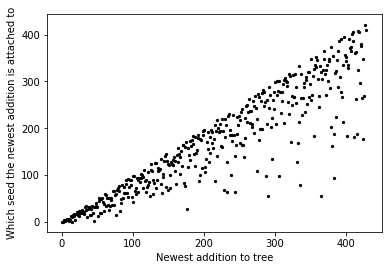

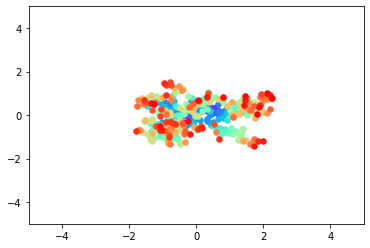

In [92]:
spawn_r = 3
max_dist = 0.0

Peter = DLA3DTree([[0,0,0]])

for j in tqdm(range(100)):
    Brownian_array = [Brown3D([1.0, 1.0, 1.0], [2.0, 2.0, 2.0], rand_len=512, r=.1) for i in
                      range(10)]

    for i in Brownian_array:
        i.start_pos_sphere(max_dist + 0.1)
        i.gen_rand()
        path = i.gen_path()
        # plt.scatter(i.path[0], i.path[1], s=40, alpha=0.5)
        indices = Peter.check_path(path)
        if indices > -1:
            Peter.add_seed(i.path[:, indices])

            # max_z = np.amax(George.seed_array, axis=0)[2]
            # origin[2] = max_z
            # final_coords[2] = max_z
            seed_l = np.linalg.norm(i.path[:, indices])
            max_dist = np.maximum(max_dist, np.linalg.norm(i.path[:, indices]))
            Peter.adjust_origin()

colors = iter(cm.rainbow(np.linspace(0, 1, len(Peter.seed_array))))

fig = plt.figure()
ax = fig.add_subplot()

for i in range(len(Peter.seed_array)):
    ax.scatter(Peter.seed_array[i][0], Peter.seed_array[i][1], s=30, color=next(colors), alpha=1)


plt.xlim(-5, 5)
plt.ylim(-5, 5)

Peter.gen_link_graph('black')

plt.show()

with open('coords.txt', 'w') as f:
    f.write(str(np.shape(Peter.seed_array)[0]) + '\n')
    f.write(str(np.shape(Peter.link_tree)[0]))
    f.write('\n')
    for coord in Peter.seed_array:
        f.write(str(coord))
        f.write('\n')
    for link in Peter.link_tree:
        f.write(str(link))
        f.write('\n')

## Blender Integration

The code beneath is not usable within jupyter notebook, but has to be copied into a blender script. From there, first press shift + c in the viewport to reset the camera and 3d cursor. Upon activating the script, you should see a sticks-and-marbles representation of the DLA tree that was generated. The code runs on itself for the most part, you just need to add the address where the .txt file is.

The code generates two spheres and a cylinder between them for every link described in the exported .txt file. I will warn you, it can take quite a while to generate all that geometry if you get into the range of 1000 links between particles.

Once the model is imported, if one wishes to make life easier on themselves, it is advised to select all surface objects (the spheres) and press ctrl + j to join them all into one object. Do the same with all the curve objects (the links). The resulting mesh is a lot less taxing on your computer. From here, you can put whatever shaders you want on your objects.

In [93]:
import bpy
import numpy as np
from pathlib import Path

def gen_branch(sphere_rad, cyl_rad, loc1, loc2):

# add sphere1
    bpy.ops.surface.primitive_nurbs_surface_sphere_add(radius=sphere_rad, location=loc1)

    # add sphere2
    bpy.ops.surface.primitive_nurbs_surface_sphere_add(radius=sphere_rad, location=loc2)

    # add a curve to link them together
    bpy.ops.curve.primitive_bezier_curve_add()
    obj = bpy.context.object
    obj.data.dimensions = '3D'
    obj.data.fill_mode = 'FULL'
    obj.data.bevel_depth = cyl_rad
    obj.data.bevel_resolution = 4
    # set first point to centre of sphere1
    obj.data.splines[0].bezier_points[0].co = loc1
    obj.data.splines[0].bezier_points[0].handle_left_type = 'VECTOR'
    obj.data.splines[0].bezier_points[0].handle_right_type = 'VECTOR'
    # set second point to centre of sphere2
    obj.data.splines[0].bezier_points[1].co = loc2
    obj.data.splines[0].bezier_points[1].handle_left_type = 'VECTOR'
    obj.data.splines[0].bezier_points[1].handle_right_type = 'VECTOR'
    return True


# Here is where you need to put the address to the coordinates.
coords_path = 'C:/Users/night_3ns60sk/OneDrive/Documenten/TU_algemeen/DLA_project/coords.txt'
f = Path(bpy.path.abspath(coords_path))

if f.exists():
    data = f.read_text()

data_split = data.split('\n')
data_len = int(data_split[0])
tree_len = int(data_split[1])
print(data_len)
print(tree_len)

particle_coords = np.zeros((data_len, 3), dtype=float)
tree_links = np.zeros((tree_len, 2), dtype=int)

for i in range(2, data_len+2):
    temp = data_split[i][1: -1]
    particle_coords[i-2] = np.fromstring(temp, dtype=float, count=3, sep=' ')

print('Done with getting particles')

for j in range(data_len+2, data_len+tree_len+2):
    temp_tree = data_split[j][1: -1]
    print(temp_tree)
    tree_links[j-data_len-2] = np.fromstring(temp_tree, dtype=int, count=2, sep=', ')
    
print('Done with getting links')
print(tree_links)


# The two parameters here you can alter, they are the size of the spheres and links respectively.
for i, link in enumerate(tree_links):
    gen_branch(0.05, 0.025, particle_coords[link[0]], particle_coords[link[1]])
    if i%100 ==0:
        print('Generating branch {}'.format(i))

ModuleNotFoundError: No module named 'bpy'

## A little bit on fractal dimensions
While we have not implemented a box-counting algorithm in this code, we do want to talk a little bit about fractal dimensionality, especially as it concerns 3D structures. In the 2D case, Diffusion Limited Aggregates, especially when modeleed with a single seed point, reliably approach a fractal dimention of 1.7. We can make sense of this. While diffusive particles are good at filling up exposed areas, once they are not longer exposed, those gaps will remain there. For 3D, the fractal dimension has been determined to be 2.5  

source:
https://journals.aps.org/pre/abstract/10.1103/PhysRevE.57.784  